In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import cv2
from google.colab.patches import cv2_imshow
import pathlib
from tensorflow.keras import datasets, layers, models


In [3]:
from sklearn.metrics import precision_score, recall_score,accuracy_score,  f1_score, roc_auc_score, roc_curve

In [4]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Mounting google drive and copying over slides from professor's directory

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')


!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

The commented commands below were used to copy over data from remote drive directory to my personal drive

In [7]:
# %cd '/gdrive/MyDrive/student_share/slides'

In [8]:
# %cp -r '/gdrive/.shortcut-targets-by-id/1JS2J7v5mKLq1Gx9yEZNAydC9s2_O9Dt9/slides/.' '/gdrive/My Drive/stored_slides'

# Defining basic functions and exploring the images

In [9]:
MAGNIFICATION_LEVEL = 4
IMG_SIZE = 299
STRIDE = 100
CENTER_IMAGE = 128
drive_data  = '/gdrive/MyDrive/stored_slides/'

In [10]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels =  list(zip(indices[0], indices[1]))
    percent_tissue = len(tissue_pixels) / float(image.shape[0] * image.shape[0]) * 100
    return percent_tissue

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [11]:
def find_tumor_percentage(image):
    mask_image = image[:,:,0]
    assert mask_image.shape == (image.shape[0], image.shape[1])
    # if the pixel has value 1 then it is a tumor
    percent_tumor = np.count_nonzero(mask_image) / float(image.shape[0]*image.shape[1]) * 100
    return percent_tumor

In [12]:
def show_image_with_original_mask_on(tumor_slide_name , magnification_level = 7):
  drive_data_tumor  = drive_data+ tumor_slide_name+'.tif'
  drive_data_mask  =  drive_data+ tumor_slide_name+'_mask.tif'

  slide = open_slide(drive_data_tumor)
  slide_mask = open_slide(drive_data_mask)

  slide_image = read_slide(slide,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])
  mask_image = read_slide(slide_mask,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])
  mask_image = mask_image[:,:,0]

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

The below images are used for training and validation

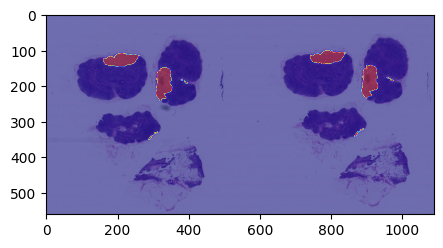

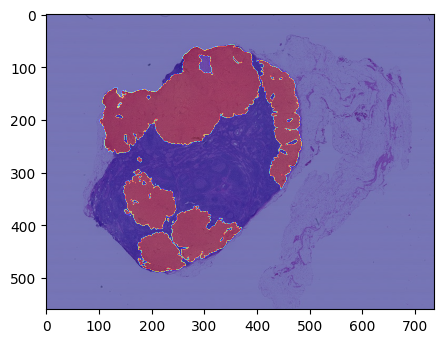

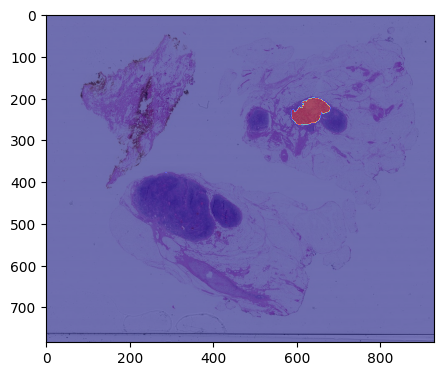

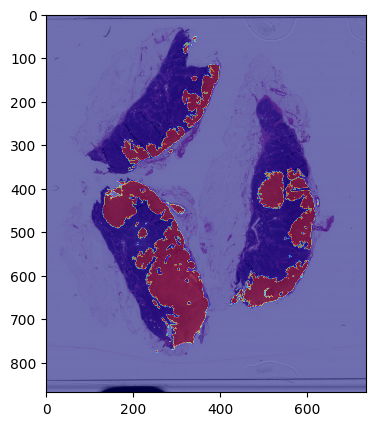

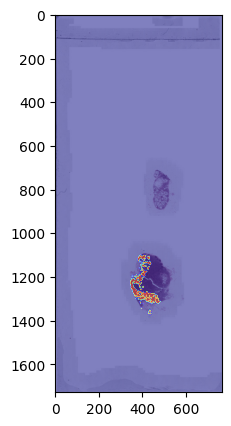

In [13]:
show_image_with_original_mask_on('tumor_101')   
show_image_with_original_mask_on('tumor_110') 
show_image_with_original_mask_on('tumor_094')
show_image_with_original_mask_on('tumor_078')
show_image_with_original_mask_on('tumor_031') 

The below images are used for testing and heat map generation

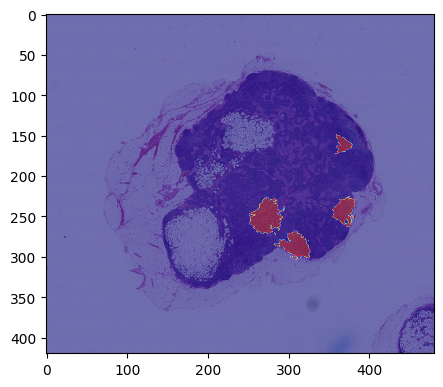

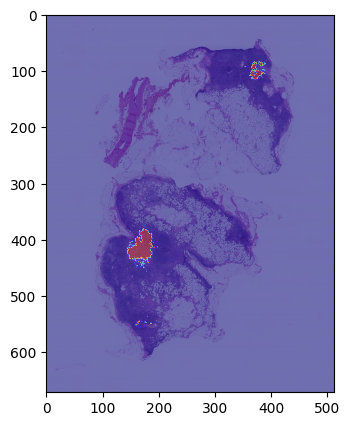

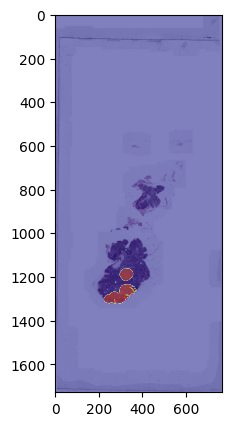

In [14]:
show_image_with_original_mask_on('tumor_091') 
show_image_with_original_mask_on('tumor_084') 
show_image_with_original_mask_on('tumor_016') 

# Generating train and test data using sliding window approach

## Generating training data

In [17]:
def create_images_from_slides(tissue_file, mask_file, magnification_level=MAGNIFICATION_LEVEL, sq_window_size = IMG_SIZE , stride = STRIDE , center_image = CENTER_IMAGE):
 drive_data_tumor  = drive_data+ tissue_file +'.tif'
 drive_data_mask  =  drive_data+ mask_file +'.tif'

 cancerous , non_cancerous = [] , []
 cancerous_label , non_cancerous_label = [] ,  []

 slide = open_slide(drive_data_tumor)
 slide_mask = open_slide(drive_data_mask)

 downsample_size = int(slide.level_downsamples[magnification_level])
 slide_width = slide.level_dimensions[magnification_level][0]
 slide_height = slide.level_dimensions[magnification_level][1]

 for x in range(0,slide_width - sq_window_size , stride):
  for y in range(0,slide_height - sq_window_size , stride): 
   #finding the tumor percentage to remove classify cancerous and non cancerous cells
   mask_image = read_slide(slide_mask, x = x*downsample_size, y = y*downsample_size, level=magnification_level,  width=sq_window_size,  height=sq_window_size) 
   
   #finding the center patch of the mask image to use for classification
   offset = int((mask_image.shape[0]-center_image)/2)
   center_mask_image = mask_image[offset:offset+center_image, offset:offset+center_image]
  
   tumor_percentage = find_tumor_percentage(center_mask_image)
	
	 #finding tissue percentage to remove the gray scale area
   slide_image = read_slide(slide, x = x*downsample_size, y = y*downsample_size, level=magnification_level, width=sq_window_size, height=sq_window_size)
   percentage_tissue = find_tissue_pixels(slide_image)

   if percentage_tissue > 20:
    if tumor_percentage > 1:
     cancerous.append(slide_image)
     cancerous_label.append(1)      
    else:
     non_cancerous.append(slide_image)
     non_cancerous_label.append(0)  
 return cancerous , cancerous_label, non_cancerous , non_cancerous_label

In [18]:
def generate_patches_from_slides_arr(slides_arr):
  cancerous_arr , cancerous_label_arr, non_cancerous_arr , non_cancerous_label_arr = [] ,[] , [] ,[] 

  for s in slides_arr : 
    cancerous , cancerous_label, non_cancerous , non_cancerous_label = create_images_from_slides(tissue_file = s ,mask_file= s +'_mask')
    cancerous_arr.extend(cancerous)
    cancerous_label_arr.extend(cancerous_label)
    non_cancerous_arr.extend(non_cancerous)
    non_cancerous_label_arr.extend(non_cancerous_label)

  return cancerous_arr , cancerous_label_arr, non_cancerous_arr , non_cancerous_label_arr

In [19]:
#Generate the files using image names 

slides_for_training_model = ['tumor_101','tumor_110','tumor_094','tumor_078','tumor_031']

cancerous_arr , cancerous_label_arr, non_cancerous_arr , non_cancerous_label_arr  = generate_patches_from_slides_arr(slides_for_training_model)

Saving the data generated for quick access in case program crashes due to RAM overload

In [20]:
np.save('/content/cancerous_arr' ,cancerous_arr)
np.save('/content/cancerous_label_arr' ,cancerous_label_arr)
np.save('/content/non_cancerous_arr' ,non_cancerous_arr)
np.save('/content/non_cancerous_label_arr' ,non_cancerous_label_arr)

In [23]:
cancerous_label_np_arr =  np.load('/content/cancerous_label_arr.npy')
number_of_cancerous_samples = len(cancerous_label_np_arr)
print(number_of_cancerous_samples)

1557


In [24]:
non_cancer_dataset = tf.data.Dataset.from_tensor_slices((np.load('/content/non_cancerous_arr.npy'), np.load('/content/non_cancerous_label_arr.npy')))

In [25]:
non_cancer_dataset.shuffle(5000)
non_cancer_dataset = non_cancer_dataset.take(number_of_cancerous_samples)

In [26]:
cancer_dataset = tf.data.Dataset.from_tensor_slices((np.load('/content/cancerous_arr.npy'), np.load('/content/cancerous_label_arr.npy')))

## Generating the test data

In [27]:
slides_for_testing_model = ['tumor_091','tumor_084','tumor_016']
cancerous_arr_test , cancerous_label_arr_test, non_cancerous_arr_test , non_cancerous_label_arr_test  = generate_patches_from_slides_arr(slides_for_testing_model)

In [28]:
print(len(non_cancerous_label_arr_test))
print(len(cancerous_label_arr_test))

1557
205


In [29]:
test_images = cancerous_arr_test + non_cancerous_arr_test
test_labels = cancerous_label_arr_test +  non_cancerous_label_arr_test

# Undersampling the training data and training the models


Undersampling and making data into tensorflow datasets

In [30]:
resampled_ds = tf.data.experimental.sample_from_datasets([cancer_dataset, non_cancer_dataset], weights=[0.5, 0.5])
resampled_ds.shuffle(seed=123, buffer_size= 6000)

<ShuffleDataset shapes: ((299, 299, 3), ()), types: (tf.uint8, tf.int64)>

In [31]:
training_sample_size = (2*number_of_cancerous_samples)
print(training_sample_size)
training_sample_size = (training_sample_size*8)//10
print(training_sample_size)

3114
2491


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_sample = resampled_ds.take(training_sample_size) 
validation_sample = resampled_ds.skip(training_sample_size)#.batch(32)

train_sample = train_sample.cache()
train_sample = train_sample.batch(32)
train_sample = train_sample.prefetch(buffer_size=AUTOTUNE)

validation_sample = validation_sample.cache()
validation_sample = validation_sample.batch(32)
validation_sample = validation_sample.prefetch(buffer_size=AUTOTUNE)

Training the models 

In [33]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [35]:
inception  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))
inception.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [36]:
inception_model_pre_process= tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1. / 255),
  tf.keras.layers.Lambda(lambda x: x-0.5),
  tf.keras.layers.Lambda(lambda x: x*2.) ])

In [37]:



inception_model= tf.keras.Sequential([
  inception_model_pre_process,
  inception,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])
inception_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 38,580,386
Trainable params: 16,777,602
Non-trainable params: 21,802,784
_________________________________________________________________


In [39]:
history = inception_model.fit(train_sample, validation_data=validation_sample, epochs=25)

Epoch 1/25
78/78 [==============================] - 66s 366ms/step - loss: 7.7560 - accuracy: 0.6440 - val_loss: 0.8534 - val_accuracy: 0.7849
Epoch 2/25
78/78 [==============================] - 12s 153ms/step - loss: 0.4105 - accuracy: 0.9057 - val_loss: 1.8513 - val_accuracy: 0.6308
Epoch 3/25
78/78 [==============================] - 12s 154ms/step - loss: 0.8188 - accuracy: 0.8433 - val_loss: 1.2700 - val_accuracy: 0.6982
Epoch 4/25
78/78 [==============================] - 12s 155ms/step - loss: 0.5240 - accuracy: 0.8727 - val_loss: 0.6181 - val_accuracy: 0.8234
Epoch 5/25
78/78 [==============================] - 12s 157ms/step - loss: 0.2581 - accuracy: 0.9092 - val_loss: 0.8768 - val_accuracy: 0.7592
Epoch 6/25
78/78 [==============================] - 12s 158ms/step - loss: 0.4612 - accuracy: 0.8714 - val_loss: 0.5760 - val_accuracy: 0.8154
Epoch 7/25
78/78 [==============================] - 12s 159ms/step - loss: 0.1807 - accuracy: 0.9351 - val_loss: 0.5301 - val_accuracy: 0.8363

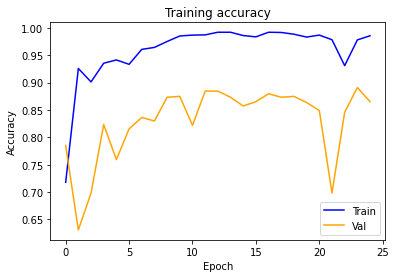

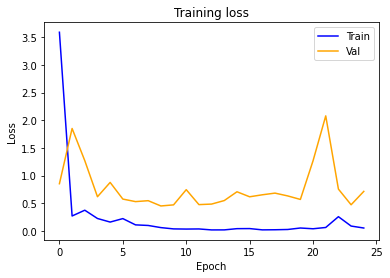

In [40]:
plot(history)

In [41]:
inception_model.save("/gdrive/MyDrive/inception_model.h5")

Creating augmented version of the model

In [42]:
inception_augmented_model= tf.keras.Sequential([
  inception_model_pre_process,
  data_augmentation,                                 
  inception,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])
inception_augmented_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
inception_augmented_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 38,580,386
Trainable params: 16,777,602
Non-trainable params: 21,802,784
_________________________________

In [44]:
history = inception_augmented_model.fit(train_sample, validation_data=validation_sample, epochs=25)

Epoch 1/25
78/78 [==============================] - 19s 179ms/step - loss: 7.4754 - accuracy: 0.7180 - val_loss: 2.2471 - val_accuracy: 0.8138
Epoch 2/25
78/78 [==============================] - 13s 166ms/step - loss: 4.4161 - accuracy: 0.7261 - val_loss: 0.8567 - val_accuracy: 0.8026
Epoch 3/25
78/78 [==============================] - 13s 166ms/step - loss: 0.9075 - accuracy: 0.7771 - val_loss: 0.5091 - val_accuracy: 0.7865
Epoch 4/25
78/78 [==============================] - 13s 166ms/step - loss: 0.4871 - accuracy: 0.7984 - val_loss: 0.5965 - val_accuracy: 0.7640
Epoch 5/25
78/78 [==============================] - 13s 165ms/step - loss: 0.5698 - accuracy: 0.7947 - val_loss: 0.3106 - val_accuracy: 0.8925
Epoch 6/25
78/78 [==============================] - 13s 164ms/step - loss: 0.6083 - accuracy: 0.8165 - val_loss: 0.3630 - val_accuracy: 0.8443
Epoch 7/25
78/78 [==============================] - 13s 164ms/step - loss: 0.4990 - accuracy: 0.8257 - val_loss: 0.3537 - val_accuracy: 0.8459

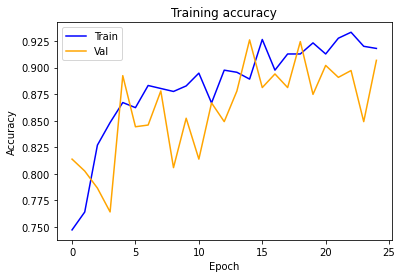

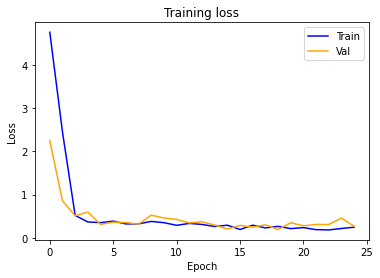

In [45]:
plot(history)

In [46]:
inception_augmented_model.save("/gdrive/MyDrive/inception_augmented_model.h5")

Creating a Fine tuned version of the model

In [47]:
inception_fine_tuned  = tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(IMG_SIZE, IMG_SIZE, 3))
inception_fine_tuned.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception_fine_tuned.layers))

# Fine-tune from this layer onwards
fine_tune_at = 270

# Freeze all the layers before the `fine_tune_at` layer
for layer in inception_fine_tuned.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [48]:
inception_fine_tuned_model= tf.keras.Sequential([
  inception_model_pre_process,                                
  inception_fine_tuned,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])
inception_fine_tuned_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
inception_fine_tuned_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 38,580,386
Trainable params: 22,851,330
Non-trainable params: 15,729,056
_________________________________________________________________


In [50]:
history = inception_fine_tuned_model.fit(train_sample, validation_data=validation_sample, epochs=6)

Epoch 1/6
78/78 [==============================] - 22s 204ms/step - loss: 4.5916 - accuracy: 0.7244 - val_loss: 2.6159 - val_accuracy: 0.5891
Epoch 2/6
78/78 [==============================] - 14s 184ms/step - loss: 0.3005 - accuracy: 0.8965 - val_loss: 0.5716 - val_accuracy: 0.8202
Epoch 3/6
78/78 [==============================] - 14s 184ms/step - loss: 0.1022 - accuracy: 0.9612 - val_loss: 0.5939 - val_accuracy: 0.8555
Epoch 4/6
78/78 [==============================] - 14s 182ms/step - loss: 0.0611 - accuracy: 0.9776 - val_loss: 0.6819 - val_accuracy: 0.8347
Epoch 5/6
78/78 [==============================] - 14s 181ms/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 0.7968 - val_accuracy: 0.8443
Epoch 6/6
78/78 [==============================] - 14s 181ms/step - loss: 3.9355e-04 - accuracy: 1.0000 - val_loss: 0.6947 - val_accuracy: 0.8539


In [51]:
inception_fine_tuned_model.save("/gdrive/MyDrive/inception_fine_tuned_model.h5")

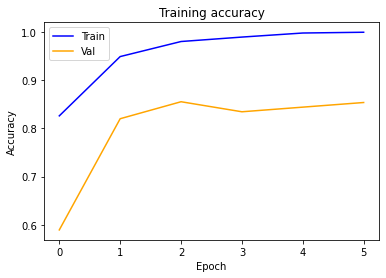

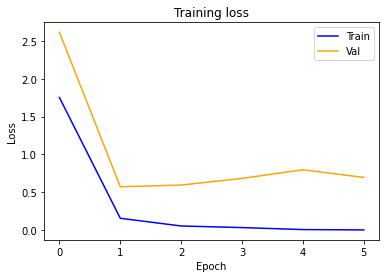

In [52]:
plot(history)

# Evaluation of the models by obtaining metrics and generating heatmap

In [53]:
def print_metrics_on_test_data(model , test_images , test_labels):
  predicted_test_labels = []

  for test_image in test_images:
    test_image_temp = tf.expand_dims(test_image, axis=0)
    test_prediction = model.predict(test_image_temp)
    test_pred = np.argmax(test_prediction)
    predicted_test_labels.append(test_pred)
    
  accuracy= accuracy_score(test_labels,predicted_test_labels)
  recall= recall_score(test_labels,predicted_test_labels)
  f1= f1_score(test_labels,predicted_test_labels)
  auc= roc_auc_score(test_labels,predicted_test_labels)

  print('accuracy ',accuracy)
  print('recall ',recall)
  print('f1 ',f1)
  print('auc ',auc)


In [54]:
print_metrics_on_test_data(inception_model, test_images , test_labels)

accuracy  0.764472190692395
recall  0.7317073170731707
f1  0.4195804195804196
auc  0.7502467221204004


In [55]:
print_metrics_on_test_data(inception_augmented_model, test_images , test_labels)

accuracy  0.8132803632236095
recall  0.5756097560975609
f1  0.4176991150442477
auc  0.7100913263467895


In [56]:
print_metrics_on_test_data(inception_fine_tuned_model, test_images , test_labels)

accuracy  0.7338251986379115
recall  0.8097560975609757
f1  0.41448189762796506
auc  0.7667919858389336


## Functions for generating heatmap

In [57]:
def generate_heat_map_mask(passed_model, tissue_file, magnification_level=MAGNIFICATION_LEVEL, sq_window_size = IMG_SIZE, stride = IMG_SIZE ):
 drive_data_tumor  = drive_data+ tissue_file +'.tif'
 slide = open_slide(drive_data_tumor)

 downsample_size = int(slide.level_downsamples[magnification_level])
 slide_width = slide.level_dimensions[magnification_level][0]
 slide_height = slide.level_dimensions[magnification_level][1]

 mask = np.full(shape= (slide_height, slide_width), fill_value= 0)

 for x in range(0,slide_width - sq_window_size , stride):
  for y in range(0,slide_height -sq_window_size , stride): 
   slide_image = read_slide(slide, x = x*downsample_size, y = y*downsample_size, level=magnification_level, width=sq_window_size, height=sq_window_size)
   
   percentage_tissue = find_tissue_pixels(slide_image)

   if percentage_tissue >= 20:
     
      slide_image_temp = tf.expand_dims(slide_image, axis=0)
      prediction = passed_model.predict(slide_image_temp)
      pred = np.argmax(prediction)

      if pred==1 :  ## cancerous is 1
        mask[x:x+IMG_SIZE, y:y+IMG_SIZE] = 1
      else:
        continue

 return mask


In [58]:
def model_show_image_with_mask_on(model , tumor_slide_name, magnification_level = MAGNIFICATION_LEVEL):
  mask_image = generate_heat_map_mask(model , tumor_slide_name)

  drive_data_tumor  = drive_data+ tumor_slide_name+'.tif'

  slide = open_slide(drive_data_tumor)
  slide_image = read_slide(slide,x=0, y=0, level=magnification_level, width=slide.level_dimensions[magnification_level][0], height=slide.level_dimensions[magnification_level][1])

  plt.figure(figsize=(5,5), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

## Heat map ground truth and prediction with different models

### tumor_091

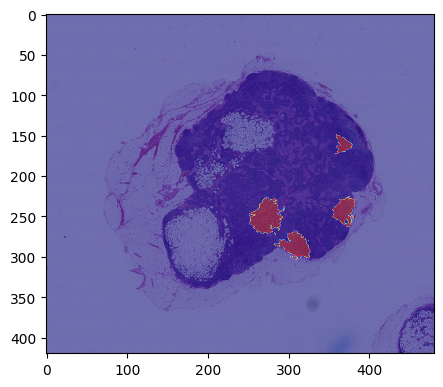

In [59]:
#ground truth 
show_image_with_original_mask_on('tumor_091')

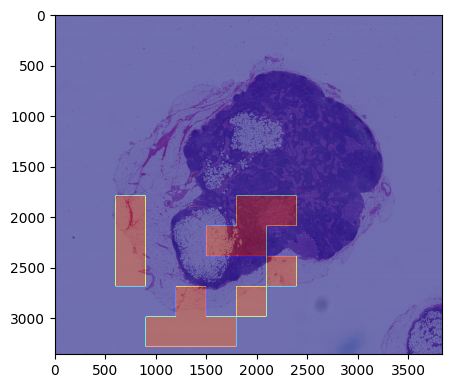

In [60]:
model_show_image_with_mask_on(inception_model , 'tumor_091')

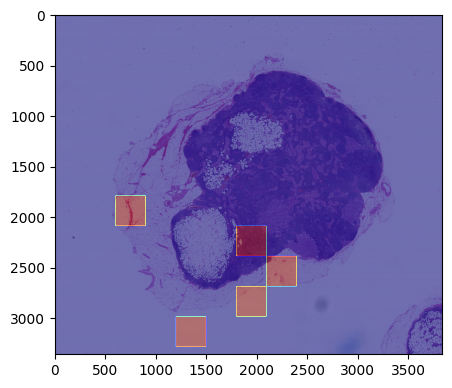

In [61]:
model_show_image_with_mask_on(inception_augmented_model , 'tumor_091')

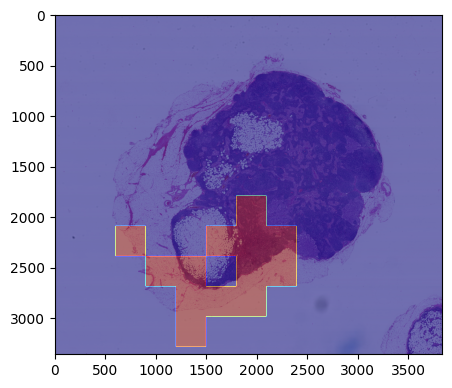

In [62]:
model_show_image_with_mask_on(inception_fine_tuned_model , 'tumor_091')

### tumor_084

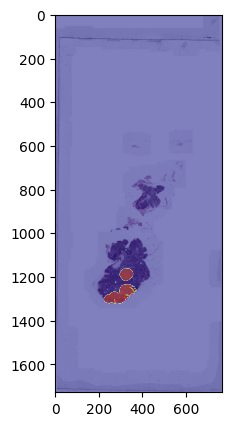

In [63]:
#ground truth 
show_image_with_original_mask_on('tumor_016')

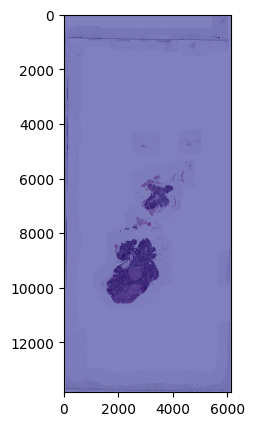

In [64]:
model_show_image_with_mask_on(inception_model , 'tumor_016')

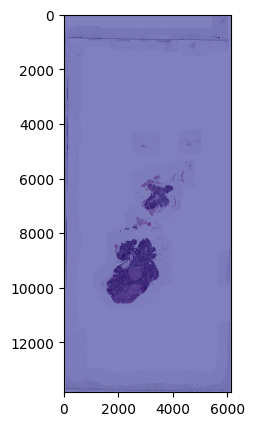

In [65]:
model_show_image_with_mask_on(inception_augmented_model , 'tumor_016')

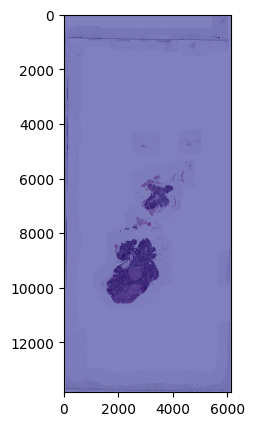

In [66]:
model_show_image_with_mask_on(inception_fine_tuned_model , 'tumor_016')